In [246]:
#Importing the Libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler,PowerTransformer
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture,GaussianMixture
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import metrics
import lightgbm as lgb
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [247]:
df = pd.read_csv("Gia SMP va SMPcap 2021(Giá thị trường SMP).csv", encoding="latin-1", sep=';')


In [248]:
feats= ['3']

In [249]:
print(df.columns)


Index(['Ngày', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48'],
      dtype='object')


In [250]:
from sklearn.preprocessing import StandardScaler
transformer = StandardScaler()
X=transformer.fit_transform(np.array(df[feats]).reshape(-1,1))


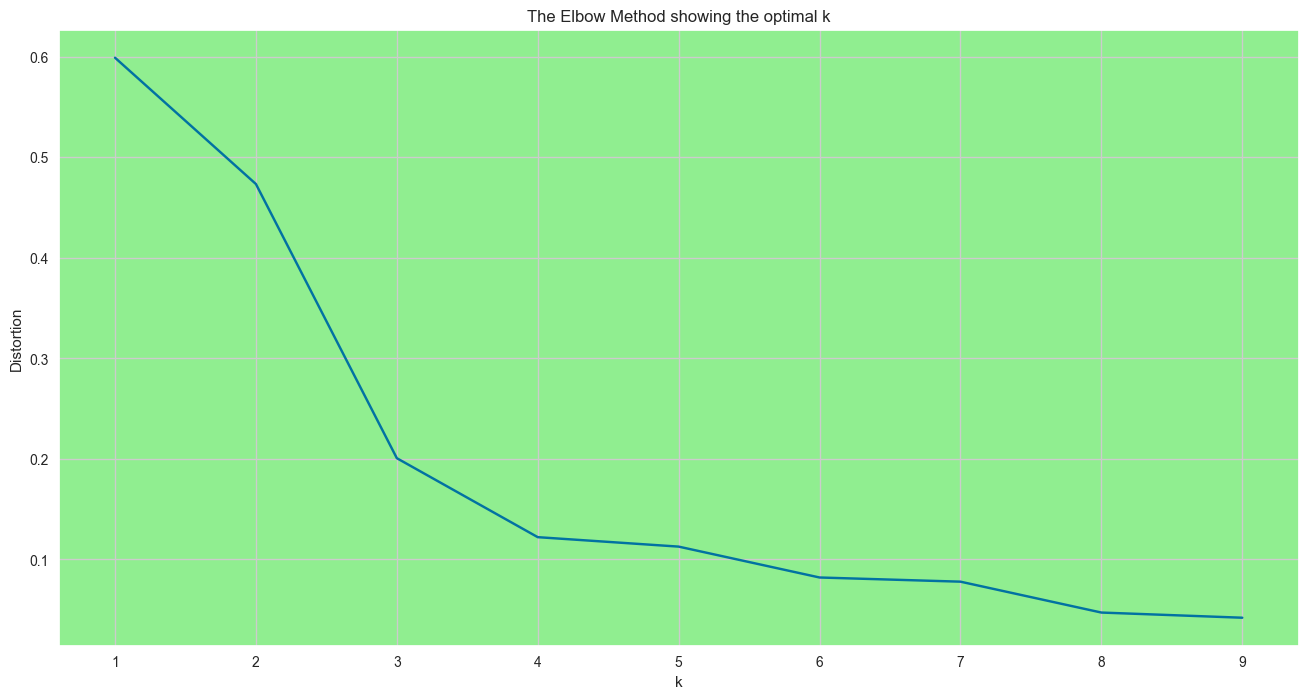

In [251]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

# Tính toán tổng bình phương khoảng cách từ mỗi điểm đến trung tâm cụm gần nhất
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Vẽ biểu đồ Elbow
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


In [252]:
BGM = BayesianGaussianMixture(n_components=3,covariance_type='full',random_state=1,n_init=15)
# fit model and predict clusters
preds = BGM.fit_predict(X)
df["Clusters"]= preds

In [253]:
pp=BGM.predict_proba(X)
df_new=pd.DataFrame(X,columns=feats)
df_new[[f'predict_proba_{i}' for i in range(3)]]=pp
df_new['preds']=preds
df_new['predict_proba']=np.max(pp,axis=1)
df_new['predict']=np.argmax(pp,axis=1)

train_index=np.array([])
for n in range(3):
    n_inx=df_new[(df_new.preds==n) & (df_new.predict_proba > 0.68)].index
    train_index = np.concatenate((train_index, n_inx))



In [254]:
from sklearn.model_selection import StratifiedKFold
X_new=df_new.loc[train_index][feats]
y=df_new.loc[train_index]['preds']

params_lgb = {'learning_rate': 0.06,'objective': 'multiclass','boosting': 'gbdt','n_jobs': -1,'verbosity': -1, 'num_classes':3}

model_list=[]

gkf = StratifiedKFold(11)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_new,y)):

    tr_dataset = lgb.Dataset(X_new.iloc[train_idx],y.iloc[train_idx],feature_name = feats)
    vl_dataset = lgb.Dataset(X_new.iloc[valid_idx],y.iloc[valid_idx],feature_name = feats)

    model = lgb.train(params = params_lgb,
                train_set = tr_dataset,
                valid_sets =  vl_dataset,
                num_boost_round = 5000,
                callbacks=[ lgb.early_stopping(stopping_rounds=300, verbose=False), lgb.log_evaluation(period=200)])

    model_list.append(model)


[200]	valid_0's multi_logloss: 0.000154344
[400]	valid_0's multi_logloss: 0.000154098
[200]	valid_0's multi_logloss: 0.000156287
[400]	valid_0's multi_logloss: 0.000155959
[200]	valid_0's multi_logloss: 0.00015775
[400]	valid_0's multi_logloss: 0.000157422
[200]	valid_0's multi_logloss: 0.000152769
[400]	valid_0's multi_logloss: 0.00015231
[200]	valid_0's multi_logloss: 0.000156112
[400]	valid_0's multi_logloss: 0.000155635
[200]	valid_0's multi_logloss: 0.000151662
[400]	valid_0's multi_logloss: 0.000151339
[200]	valid_0's multi_logloss: 0.000157657
[400]	valid_0's multi_logloss: 0.000157225
[200]	valid_0's multi_logloss: 7.81861e-06
[400]	valid_0's multi_logloss: 7.73668e-06
[600]	valid_0's multi_logloss: 7.68432e-06
[800]	valid_0's multi_logloss: 7.64549e-06
[1000]	valid_0's multi_logloss: 7.61557e-06
[1200]	valid_0's multi_logloss: 7.59184e-06
[1400]	valid_0's multi_logloss: 7.57256e-06
[1600]	valid_0's multi_logloss: 7.5566e-06
[1800]	valid_0's multi_logloss: 7.54318e-06
[2000]	va

In [255]:
lgb_preds=0
for model in model_list:
    lgb_preds+=model.predict(df_new[feats])

In [256]:
labels=np.argmax(lgb_preds,axis=1)

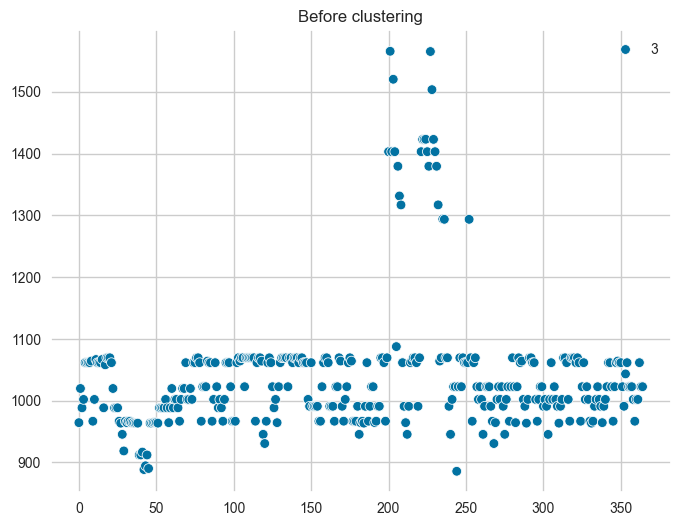

In [257]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(label="bla")
sns.scatterplot(df[feats], marker='o');
ax.set_facecolor('white')
ax.set_title("Before clustering");

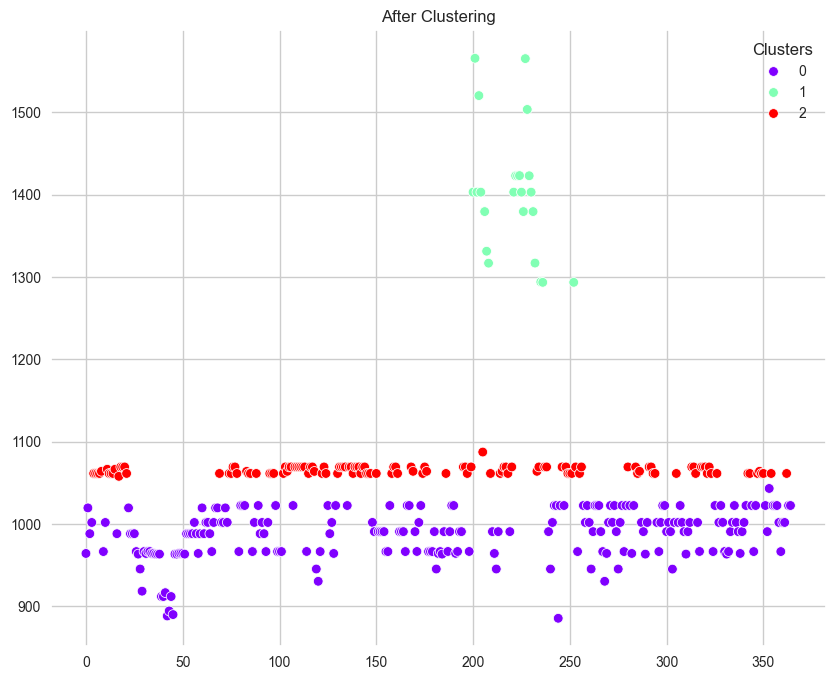

In [258]:
fig, ax = plt.subplots(figsize=(10,8))
sns.scatterplot(x=range(len(df[feats])), y=df[feats].values.flatten(), hue=df["Clusters"], palette="rainbow", ax=ax)
ax.set_title("After Clustering")
ax.set_facecolor('white')
plt.show()



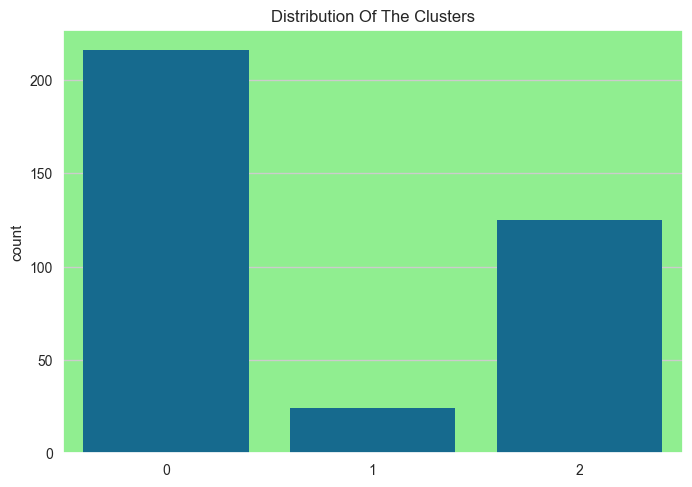

In [280]:
pl = sns.countplot(x=np.argmax(lgb_preds,axis=1))
pl.set_title("Distribution Of The Clusters")
plt.show()

In [281]:
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM

In [282]:
df['Ngày'] = pd.to_datetime(df['Ngày'], format='%d/%m/%Y')
df.sort_values(by='Ngày', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [283]:
test_size = df[df['Ngày'].dt.month==12].shape[0]
test_size

31

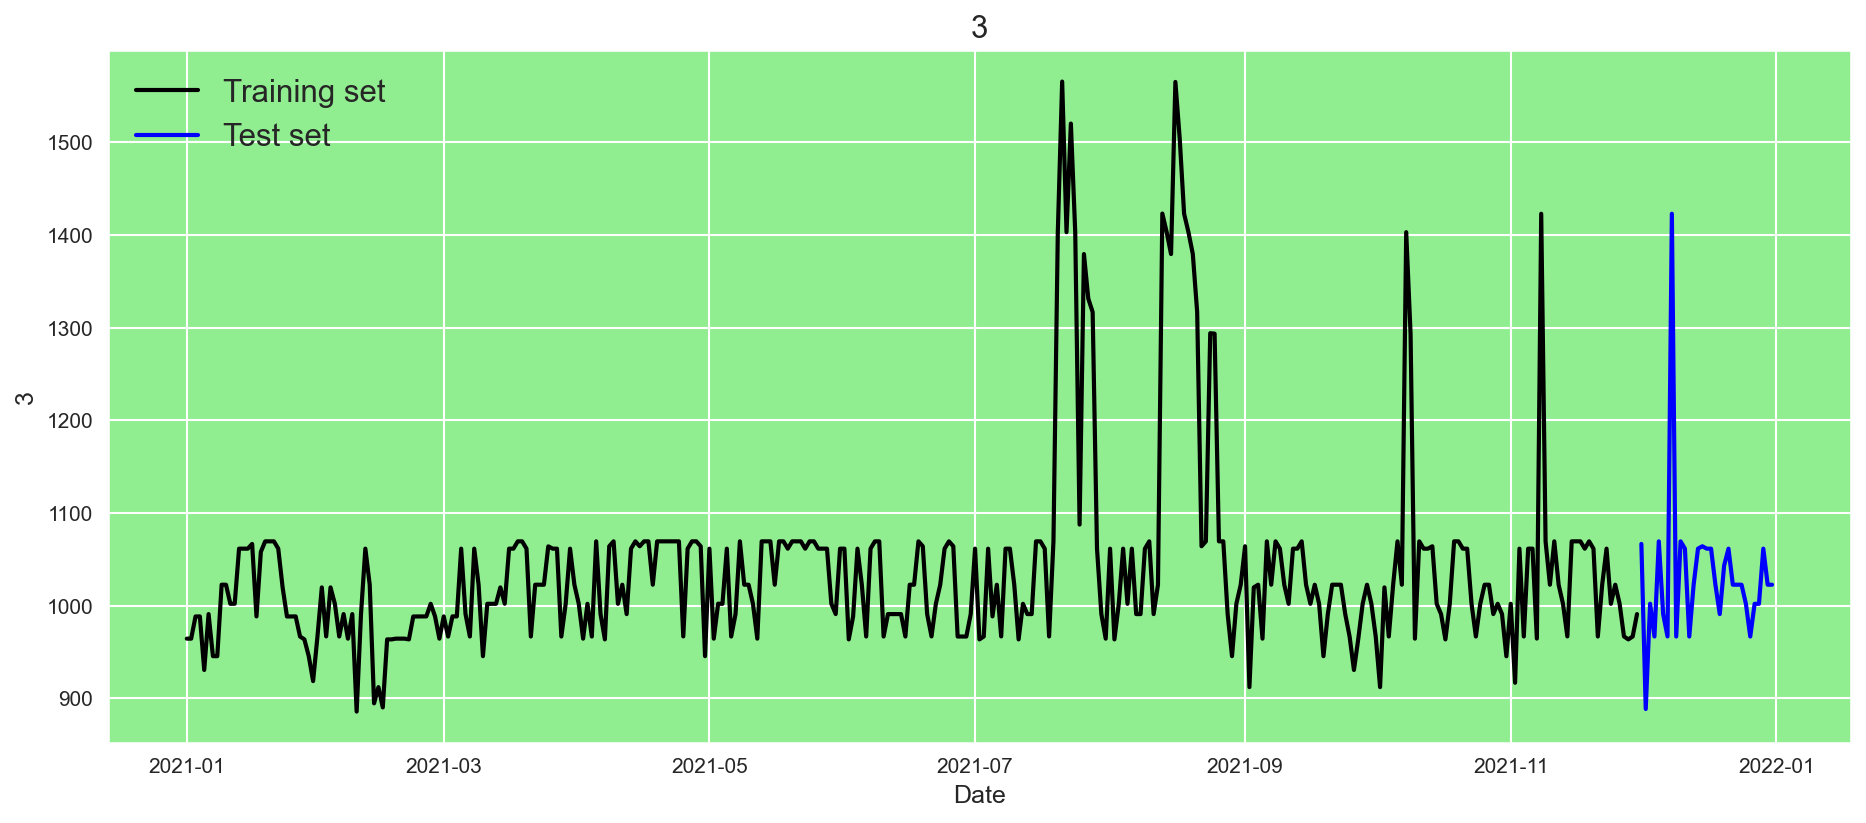

In [284]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'lightgreen'
plt.rc('axes',edgecolor='white')
plt.plot(df['Ngày'][:-test_size], df['3'][:-test_size], color='black', lw=2)
plt.plot(df['Ngày'][-test_size:], df['3'][-test_size:], color='blue', lw=2)
plt.title('3', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('3', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [285]:
import plotly.express as px
fig = px.line(y=df['4'], x=df['Ngày'])
fig.update_traces(line_color='black')
fig.update_layout(xaxis_title="Ngày",
                  yaxis_title="3",
                  title={'text': "Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(53,223,0,0.8)')

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'x=%{x}<br>y=%{y}<extra></extra>',
              'legendgroup': '',
              'line': {'color': 'black', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'scatter',
              'x': array([datetime.datetime(2021, 1, 1, 0, 0),
                          datetime.datetime(2021, 1, 2, 0, 0),
                          datetime.datetime(2021, 1, 3, 0, 0), ...,
                          datetime.datetime(2021, 12, 29, 0, 0),
                          datetime.datetime(2021, 12, 30, 0, 0),
                          datetime.datetime(2021, 12, 31, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([ 964.4,  964.4,  988.3, ..., 1061.5, 1022.6, 1022.6]),
              'yaxis': 'y'}],
    'layout': {'legend': {'tracegroupgap': 0},
               'margin': {'t': 60},
               'plot_bgcolor': 'rgba(53,223,0,0.8)',
               'template': '...',
               'title': {'text': 'Data', 'x': 0.5, 'xanchor': 'center', 'y': 0.95, 'yanchor': 'top'},
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'Ngày'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': '3'}}}
})

In [286]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df['3'].values.reshape(-1,1))

MinMaxScaler()

In [303]:
window_size = 25

In [304]:
train_data = df['3'][:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))

In [305]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-window_size:i, 0])
    y_train.append(train_data[i, 0])

In [306]:
test_data = df['3'][-test_size-window_size:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

In [307]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-window_size:i, 0])
    y_test.append(test_data[i, 0])

In [308]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [309]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [310]:
def define_model():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = 64)(input1)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()

    return model

In [316]:
model = define_model()
history = model.fit(X_train, y_train, epochs=200, batch_size=16, validation_split=0.1, verbose=1)

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 25, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0836 - val_loss: 0.0202
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0285 - val_loss: 0.0169
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0336 - val_loss: 0.0155
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0197 - val_loss: 0.0158
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0266 - val_loss: 0.0161
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0282 - val_loss: 0.0156
Epoch 7/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0274 - val_loss: 0.0156
Epoch 8/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0362 - val_loss: 0.0155
Epoch 9/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0216 - val_loss: 0.0159
Epoch 10/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0300 - val_loss: 0.0157
Epoch 11/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0248 - val_loss: 0.0159
Epoch 12/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

In [317]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: 0.0237
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


In [318]:
from sklearn.metrics import mean_absolute_percentage_error,accuracy_score,r2_score
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1-MAPE

In [319]:
print("Loss:", result)
print("MAPE:", MAPE)
print("Accuracy:", Accuracy)

Loss: 0.02367730811238289
MAPE: 2.0297906924004314
Accuracy: -1.0297906924004314


In [320]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

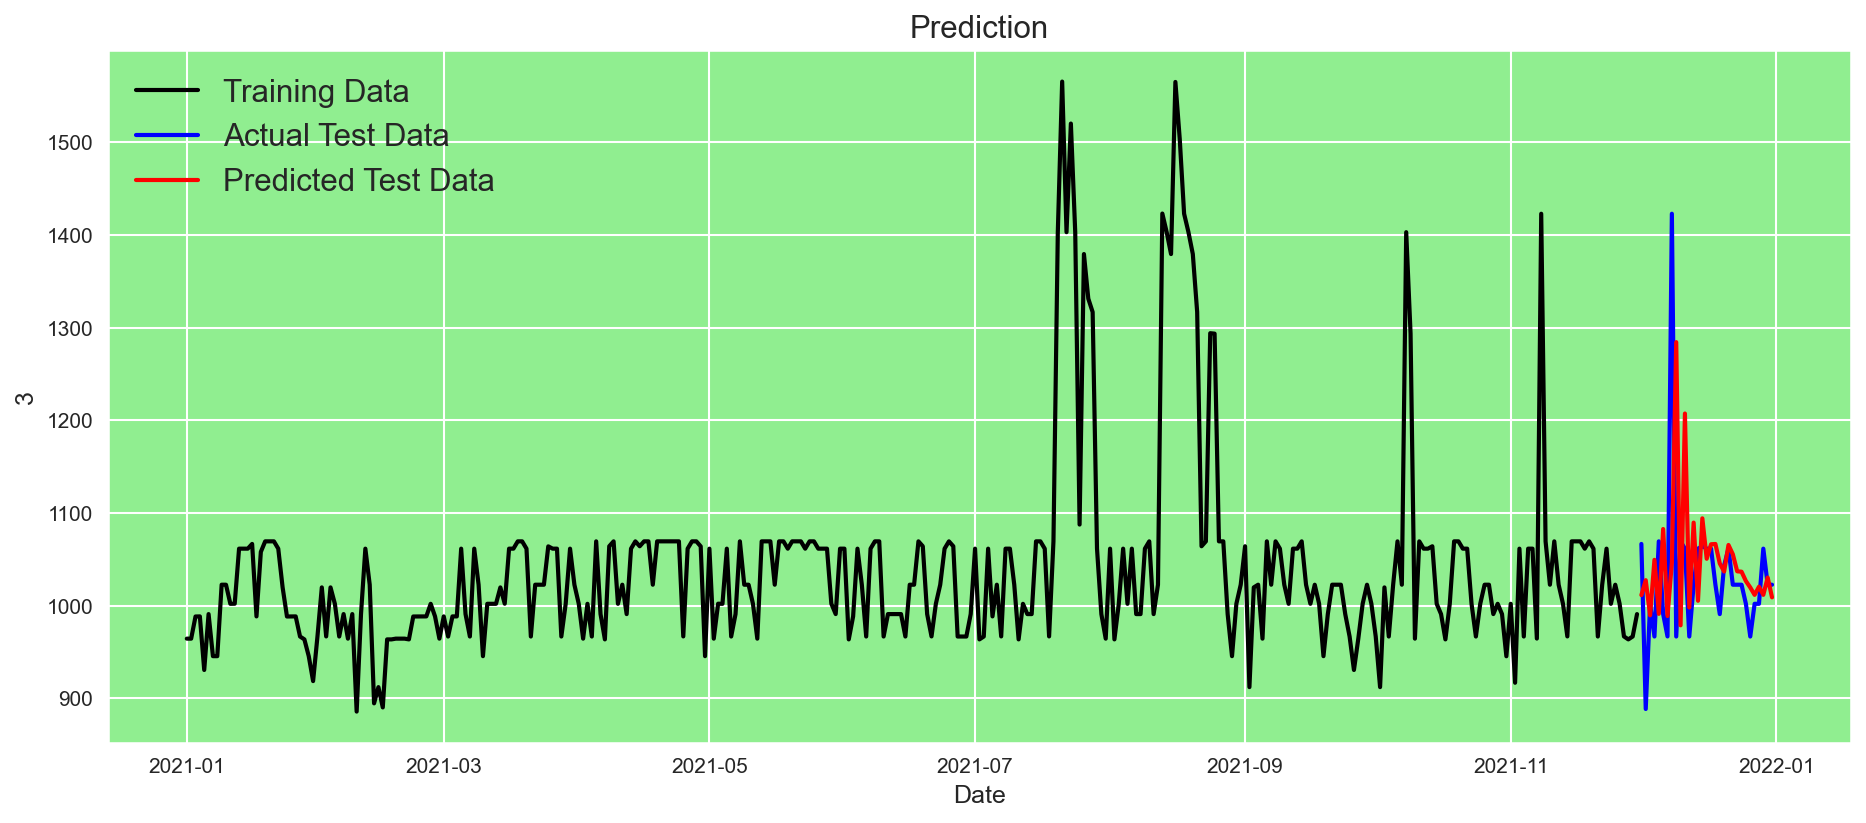

In [322]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'lightgreen'
plt.rc('axes',edgecolor='white')
plt.plot(df['Ngày'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df['Ngày'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df['Ngày'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('3', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()